In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn

from torchmeta.datasets.helpers import omniglot
from torchmeta.datasets import Omniglot
from torchmeta.utils.data import BatchMetaDataLoader
import matplotlib.pyplot as plt
from torchmeta.transforms import Categorical
from dotted.utils import dot
import hypernet as hn
from tqdm import tqdm
import numpy as np
import pandas as pd
import altair as alt

from IPython.display import clear_output, display
from time import time

In [3]:
rows = []

for x in range(100):
    row = {"x": x, "y": x +(x % 2), "z": x+(x % 5)}
    rows.append(row)
    
    df =  pd.DataFrame(rows)
    clear_output()
    chart = alt.Chart(data=df).mark_line(point=True).encode(x="x", y="y", color="z").interactive()
    display(chart)


alt.Chart(...)

In [4]:
display(chart)

alt.Chart(...)

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [6]:
N, K = 5, 5

dataset = omniglot("data", ways=N, shots=K, test_shots=15, meta_train=True, download=True)
dataloader = BatchMetaDataLoader(
    dataset, batch_size=32, num_workers=0, 
    shuffle=True
)

In [7]:
for T in dataloader:
    break

/home/mprzewie/.anaconda3/envs/uj/lib/python3.8/site-packages/torchvision/transforms/functional.py:942: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


In [8]:
def plot_task(
    x_train, y_train, x_test, y_test, n
):
    for (t, x,y) in [("train",x_train, y_train), ("test", x_test, y_test)]:
        k = len(x) // n
        fig, ax = plt.subplots(n, k, figsize=(1.5*k, 1.5*n))
        for n_ in range(n):
            for k_ in range(k):
                i = n_*k + k_
                ax[n_,k_].imshow(x[i].squeeze())
                ax[n_,k_].set_title(f"{y[i]}")
                ax[n_,k_].axis("off")
        fig.suptitle(t)
        
        
#     print([t.shape for t in [x_train, y_train, x_test, y_test]])

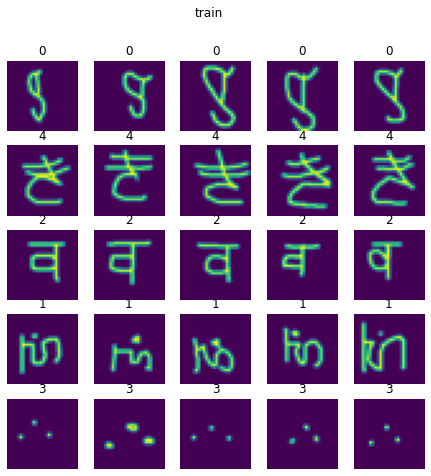

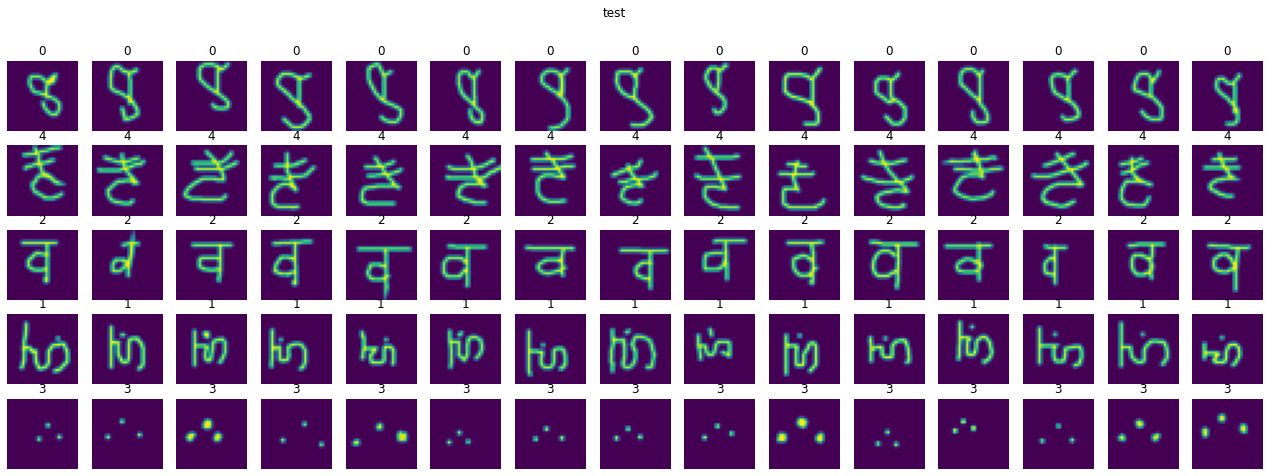

In [9]:
x_train, y_train = T["train"]
x_test, y_test = T["test"]

plot_task(x_train[0], y_train[0], x_test[0], y_test[0], N)

In [10]:
hypernet = hn.HyperNetwork(
#     target_network=target_net,
    n=N, k=K,
    hidden_size=32
)
hypernet.to(device)

loss_fn = nn.CrossEntropyLoss()
h_opt = torch.optim.Adam(hypernet.parameters(), lr=4e-4)
sum(p.numel() for p in hypernet.parameters())

392778

In [11]:
n_tasksets = 500
taskset_epochs = 10

rows = []
step = 0

for task_set_id, tasks in enumerate(tqdm(dataloader, total=n_tasksets)):
    
    if task_set_id > 50:
        taskset_epochs = 5
    if task_set_id > 100:
        taskset_epochs = 2
    if task_set_id > 200:
        taskset_epochs = 1

    for e in range(taskset_epochs):
        X_train, Y_train = tasks["train"]
        X_test, Y_test = tasks["test"]

        X_train, X_test, Y_train, Y_test = [t.to(device) for t in [X_train, X_test, Y_train, Y_test]]


        train_losses = []
        train_accs = []

        test_losses = []
        test_accs = []
        loss_sum = 0
        

        for t_id, (x_train, y_train, x_test, y_test) in enumerate(zip(X_train, Y_train, X_test, Y_test)):
        
            tn = hypernet(x_train, y_train)
            
            y_pred_train = tn(x_train)
            
            y_pred_test = tn(x_test)

            loss = loss_fn(y_pred_train, y_train) + loss_fn(y_pred_test, y_test)
            
            loss_sum = loss_sum + loss
            
            train_acc = (y_pred_train.argmax(dim=1) == y_train).sum() / len(y_train)
            
            train_losses.append(loss.item())
            train_accs.append(train_acc.item())
            
            test_acc = (y_pred_test.argmax(dim=1) == y_test).sum() / len(y_test)
            test_accs.append(test_acc.item())
            

        loss_sum.backward()
        h_opt.step()
        h_opt.zero_grad()
        
        train_row = {
            "step": step,
            "task_set_id": task_set_id,
            "epoch": e,
            "loss": np.mean(train_losses).item(),
            "accuracy":np.mean(train_accs).item(),
            "fold": "train",
        }
        
        test_row = {
            "step": step,
            "task_set_id": task_set_id,
            "epoch": e,
            "loss": np.mean(train_losses).item(),
            "accuracy":np.mean(test_accs).item(),
            "fold": "test",
        }
        rows.extend([train_row, test_row])
        step += 1
#         if e == taskset_epochs - 1:
#             print(row)
        
        df = pd.DataFrame(rows)
        chart = alt.Chart(data=df).mark_line(point=True).encode(x="step", y="accuracy", color="fold")
        clear_output()

        display(chart)
        
    
    if task_set_id == n_tasksets-1:
        break
    


alt.Chart(...)

100%|█████████▉| 499/500 [16:37<00:01,  2.00s/it]


In [12]:
df

,step,task_set_id,epoch,loss,accuracy,fold
0,0,0,0,3.229643,0.200000,train
1,0,0,0,3.229643,0.200000,test
2,1,0,1,3.227035,0.200000,train
3,1,0,1,3.227035,0.200000,test
4,2,0,2,3.224992,0.200000,train
...,...,...,...,...,...,...
2513,1256,497,0,0.672379,0.855417,test
2514,1257,498,0,0.647728,0.877500,train
2515,1257,498,0,0.647728,0.849583,test
2516,1258,499,0,0.869081,0.850000,train
